In [1]:
import os 
import pandas as pd

ITERATIONS = 2
columns=["dataset", "mtl", 'gamma', "accuracy", "precision", "recall", "duration"]
stl_results_fcn = pd.DataFrame(columns=columns)
stl_results_res = pd.DataFrame(columns=columns)



for idx, dataset in enumerate(['Beef']):#, 'Beef', 'GunPoint']):#,'Beef']):#enumerate(os.listdir('./archives/ucr')):

    bac = 0; acc=0; precision=0; recall=0; duration=0

    for classifier in ['ae_iter','conv_iter']: 

        for gamma in [1]:

            stl_results_fcn_i = pd.DataFrame(columns=columns)
            stl_results_res_i = pd.DataFrame(columns=columns)

            for itr in range(ITERATIONS): 
                fcn_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_raw"}/df_best_model.csv')
                fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_4/fcn/fcn_mt_{classifier}_{gamma}_{itr}/{"fcn_ig_raw"}/task1_df_metrics.csv')
                #res_model = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/df_best_model.csv')
                #res_metrics = pd.read_csv(f'./results/ucr/{dataset}/experiment_3/resnet/resnet_mt_{classifier}_{gamma}_{itr}/{"resnet_ig_raw"}/task1_df_metrics.csv')

                

                fcn_vals = [fcn_metrics["accuracy"].values[0], fcn_metrics["precision"].values[0],
                            fcn_metrics["recall"].values[0], fcn_metrics["duration"].values[0]] 
                #res_vals = [res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                #            res_metrics["recall"].values[0], res_metrics["duration"].values[0]] 
                #Read STL results for FCN classifier
                if itr == 0:
                    stl_results_fcn_i.loc[idx] = [dataset,classifier,gamma] + fcn_vals
                    #stl_results_res_i.loc[idx] = [dataset,classifier,gamma] + res_vals
                else:
                    stl_results_fcn_i.loc[idx, columns[3:]] += fcn_vals
                    #stl_results_res_i.loc[idx, columns[3:]] += res_vals

            stl_results_fcn_i.loc[idx, columns[3:]] /= ITERATIONS
            #stl_results_res_i.loc[idx, columns[3:]] /= ITERATIONS

            stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
            #stl_results_res = stl_results_res.append(stl_results_res_i)

#G:\Meine Ablage\master thesis\code/xai-tsc\results\ucr\Beef\experiment_4\fcn\fcn_mt_ae_iter_0.75_0\fcn_ig_raw\df_best_model.csv
#/results/ucr/Coffee/experiment_4/fcn/fcn_mt_ae_iter_0.75_0/fcn_ig_raw/df_best_model.csv'

#./results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_0/fcn_ig_raw/df_best_model.csv'
# results\ucr\Coffee/experiment_4/fcn\fcn_mt_test_0.75_0\fcn_ig_raw


C:\Users\boent\AppData\Local\Temp\ipykernel_25796\1999663872.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)
C:\Users\boent\AppData\Local\Temp\ipykernel_25796\1999663872.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stl_results_fcn = stl_results_fcn.append(stl_results_fcn_i)


In [2]:
stl_results_fcn

,dataset,mtl,gamma,accuracy,precision,recall,duration
0,Beef,ae_iter,1,0.600000,0.599268,0.600000,0.308486
0,Beef,conv_iter,1,0.616667,0.570299,0.616667,0.242832


In [83]:
stl_results_res

,dataset,mtl,gamma,accuracy,precision,recall,duration


### Calculate Custom Metrics for Attribution Method


In [23]:
import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np



# Load model to calculate custom metrics 
def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    

def norm(values): 
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else: 
        return normalize(values.reshape(1,-1))[0]
    
#define shared trunk
network = 'fcn' 
    
#store custom metrics for model
models_train  = dict()
models_test   = dict()
# Loop over data

archive = 'ucr'
dataset_name = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

itr=3
gamma = 0.75
for idx, dataset in enumerate(['Beef']):#, 'Beef', 'GunPoint']):#,'Beef']):
    print(dataset)
    ylen = 1
    #Just for now:

    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    #assertion,each ts has same length
    ylen = len(data[0][0])

    for model in ['fcn_mt_ae_iter']: #'fcn_mt_linear']: #['fcn_mt_ae','fcn_mt_conv', 'fcn_mt_linear']: 'fcn_mt_ae_iter',
        model_type = model.split('_')[0] 
        print(model)
        try: 


            #Load initial values after STL training
            #cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
            print(model_type)
            ig_data_stl  = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/test399_TEST', delimiter=',')
            original_data = read_dataset(data_p, archive, dataset, f'{model_type}_ig_raw', ylen)[dataset]
            
            #Load required models
            #cam_link = f'./results/ucr/{dataset}/fcn/fcn_mt_ae_0.0/fcn_cam_raw/best_model.hdf5'
            #ucr\GunPoint\experiment_1\fcn\fcn_mt_ae_0\fcn_ig_raw
        
            ig_link  = f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/last_model.hdf5'
            #f'./results/ucr/{dataset}/experiment_1/fcn/fcn_{itr}/original/
            #cam_model =keras.models.load_model(cam_link ,compile=False)
            ig_model = keras.models.load_model(ig_link ,compile=False)

            #Calculate new  attributions
            print("Calculate")
            ig_attributions = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, 
                                                        f"{model_type}_ig_raw", task=1, experiment=4)
            # train and test data
            # 1,3 are the labels:  
            for t in [1,3]:#,3]:
                
                tc = t 
                #Pearson and mse [p,m]
                pm1 = 0; pm2 = 0; mm1 = 0; mm2 = 0
                #predict values for all timeseries 
                print("pred", t, data[t-1].shape)

                pred = ig_model.predict(data[t-1])
                #run loop
                for ts in range(len(data[t])):                
                    #small workaround
                    #structure of attributions 0 --> train 1 --> test set
                    pm1 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_data_stl[ts]))[0,1]
                    pm2 += np.corrcoef(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))[0,1]
                    mm1 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_data_stl[ts]))
                    mm2 += mean_squared_error(norm(pred[1][ts].flatten()),norm(ig_attributions[0 if t == 1 else 1][ts][2]))
                #Init for model 
                l = len(data[t])
                if t == 1: 
                    #f'{dataset}_{model.split("_")[-1]}'
                    models_train[f'{dataset}_{model.split("_")[-2]}'] = {"model" : model, "pm1":pm1/l,"pm2": pm2/l,"mm1":mm1/l, "mm2": mm2/l}
                else: 
                    models_test[f'{dataset}_{model.split("_")[-2]}'] =  {"model" : model , "pm1":pm1/l, "pm2": 
                                                                         pm2/l, "mm1":mm1/l,  "mm2": mm2/l}
                
        except Exception as e: 
            print(dataset,"error", e)
            pass


 #./results/ucr/GunPoint/experiment_1/resnet/resnet_mt_conv_0/resnet_ig_raw/last_model.hdf5
 
#G:/Meine Ablage\master thesis\code\xai-tsc\results\ucr\Coffee\experiment_3\fcn\fcn_mt_conv_cas_0.75_0\fcn_ig_raw\last_model.hdf5
#G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Coffee//experiment_3/fcn/fcn_mt_conv_cas_0.75/fcn_ig_raw/last_model.hdf5
#results\ucr\Beef\experiment_4\fcn\fcn_mt_test_0.75_0\fcn_ig_raw\last_model.hdf5
#results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_1/fcn_ig_raw/last_model.hdf5

Beef
fcn_mt_ae_iter
fcn
Calculate
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef//experiment_4/fcn/fcn_mt_ae_iter_0.75_3/fcn_ig_raw/last_model.hdf5
1/1 [==============================] - 0s 93ms/step
pred 1 (30, 470)
1/1 [==============================] - 0s 419ms/step
pred 3 (30, 470)
1/1 [==============================] - 0s 97ms/step


In [25]:
import pandas as pd
pd.DataFrame(models_test).T

,mm1,mm2,model,pm1,pm2
Beef_ae,0.003286,0.002857,fcn_mt_ae_iter,0.202509,0.315362


In [87]:
#ig_data_stl  = np.loadtxt('./test_TRAIN', delimiter=',')

In [5]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas




In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

ts = 1
plt.plot(ig_data_stl[ts])
#plt.plot(original_data[3][ts])
#plt.plot(ig_attributions[0][ts][2])

print(t)

print(np.corrcoef(ig_data_stl[ts], pred[1][ts].flatten()))
print(np.corrcoef(ig_data_stl[ts], pred[1][ts].flatten()))

plt.plot(pred[1][ts].flatten())
plt.show()




NameError: name 'ig_data_stl' is not defined

In [16]:
model = 'fcn_mt_conv_iter'
def calculate_ig_attributions(root_dir, archive_name, classifier, dataset_name, 
                              data_source, datasets_dict = None, task=0, experiment=1):
     

    model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                    f'/experiment_{experiment}/{classifier.split("_")[:-1][0]}/'\
                    f'{classifier}/{data_source}/last_model.hdf5'  
    print(model_path)   
    #model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
    #                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
    #                                + f'last_model.hdf5'
    model =keras.models.load_model(model_path ,compile=False)

    if datasets_dict == None: 
        datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
        x_train, y_train, x_test, y_test = datasets_dict[dataset_name]
    
    else: 
        x_train, y_train, x_test, y_test = datasets_dict

    output = list()
    baseline = tf.zeros(len(x_train[0]))
    
    #tf.random.uniform((1,x_train.shape[1]),minval=-1,maxval=1) # tf.zeros(len(x_train[0]))
    y_pos = list(np.unique(y_train))
    for x_vals,y_vals in [[x_train,y_train],[x_test,y_test]]:
        pred = model.predict(x_vals) if task == 0 else model.predict(x_vals)[0]
        attr = list()
        for idx,ts in enumerate(x_vals):
            series = ts
            print(ts)
            print(np.argmax(pred[idx]))
            print(task)
            ig_att = integrated_gradients(model,baseline,series.astype('float32'),
                                        np.argmax(pred[idx]),
                                        task=task)
                                        #optimize for true values
                                        #y_pos.index(y_vals[idx]),
            attr.append([y_vals[idx],x_vals[idx],ig_att])
            break
        output.append(attr)
    return output

i1 = calculate_ig_attributions(data_p, archive, f"{model}_{gamma}_{itr}", dataset, f"{model_type}_ig_raw", task=1, experiment=4)


G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef//experiment_4/fcn/fcn_mt_conv_iter_0.75_2/fcn_ig_raw/last_model.hdf5
1/1 [==============================] - 0s 187ms/step
[-0.36292   -0.36533   -0.38781   -0.40559   -0.399     -0.36658
 -0.32454   -0.31733   -0.32653   -0.30488   -0.27717   -0.27173
 -0.27581   -0.24862   -0.1957    -0.17907   -0.15147   -0.10054
 -0.084118  -0.065608  -0.052431  -0.026914   0.0054007  0.033009
  0.076304   0.093246   0.10506    0.13602    0.18768    0.22596
  0.24258    0.26308    0.27772    0.29006    0.30805    0.37268
  0.42465    0.40928    0.41294    0.45655    0.49336    0.51103
  0.51428    0.54094    0.60233    0.64291    0.66612    0.71046
  0.76087    0.8163     0.87716    0.88793    0.89985    0.93091
  0.93008    0.92788    0.90655    0.85907    0.80804    0.76913
  0.73797    0.69771    0.65587    0.63161    0.6541     0.66006
  0.63329    0.62136    0.57943    0.50622    0.40865    0.35417
  0.30272    0.24196    0.27155    0.

In [20]:
model = 'fcn_mt_conv_iter'
model_type = 'fcn'

model_path=f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(model_path ,compile=False)
baseline = tf.zeros(len(data[2][0]))
pred = ig_model.predict(data[2])
print(np.argmax(pred[0][0]))
ig_att = integrated_gradients(ig_model,baseline,data[2][0].astype('float32'),
                            np.argmax(pred[0][0]),
                            task=1)
ig_att_last = np.loadtxt(f"./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/test399_TEST", delimiter=',')
#results/ucr/Beef/experiment_4/fcn/fcn_mt_conv_iter_0.75_2/fcn_ig_raw/last_model.hdf5
#results/ucr/Beef/experiment_4/fcn/fcn_mt_conv_iter_0.75_2/fcn_ig_raw/last_model.hdf5

print(model_path)
print(i1[1][0][1] == data[2][0])
print(i1[1][0][2] == ig_att) 
print(ig_att[0] == ig_att_last[0])

1/1 [==============================] - 0s 187ms/step
2
./results/ucr/Beef/experiment_4/fcn/fcn_mt_conv_iter_0.75_2/fcn_ig_raw/last_model.hdf5
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True 

In [8]:
plt.plot(ig_att)
plt.plot(ig_att_last[0])
plt.plot(ig_model.predict(data[2])[1][0])

np.corrcoef(ig_att, ig_att_last[0])
np.corrcoef(ig_model.predict(data[2])[1][0],ig_att_last[0])

NameError: name 'plt' is not defined

240


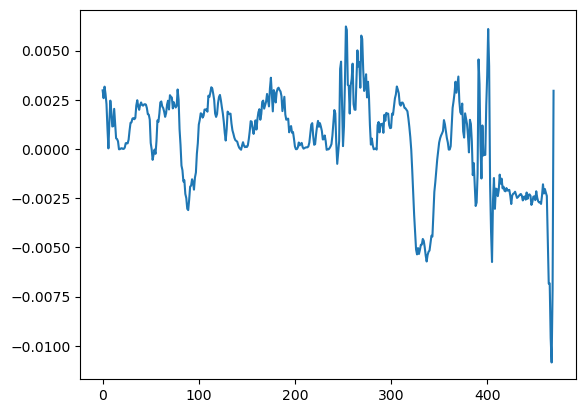

260


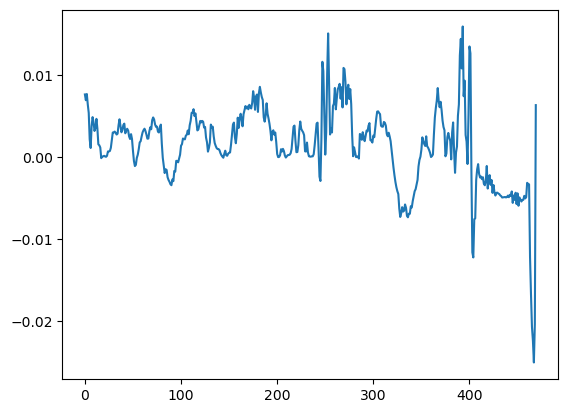

In [34]:
import numpy as np
p = "G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test200_TRAIN"
g = np.loadtxt(p, delimiter=',')

#print(g)
for  i  in range(240,250,10):
    print(i)
    p = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test{i}_TRAIN"
    g = np.loadtxt(p, delimiter=',')
    plt.plot(g[0])

plt.show()

for  i  in range(260,270,10):
    print(i)
    p = f"G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_test_0.75_3/fcn_ig_raw/test{i}_TRAIN"
    g = np.loadtxt(p, delimiter=',')
    plt.plot(g[0])

plt.show()

In [1]:
from tensorflow import keras 
dataset = 'Beef'
model_type = 'fcn'
model = 'fcn_mt_conv_iter'
gamma = 0.75
itr = 2

model_path=f'G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef/experiment_4/fcn/fcn_mt_ae_iter_freeze_0_0/fcn_ig_raw/last_model.hdf5'
ig_model = keras.models.load_model(model_path ,compile=False)

layer_names = [layer.name for layer in ig_model.layers]
for layer in ig_model.layers:
    if True: #'shared' in layer.name or 'task_1_output' in layer.name: 
        print(layer.name,layer.trainable)
        #layer.trainable = False


input_1 True
shared_l1 False
shared_l2 False
shared_l3 False
shared_l4 False
shared_l5 False
shared_l6 False
shared_l7 False
shared_l8 False
shared_l9 False
conv1d_transpose True
batch_normalization True
activation True
conv1d_transpose_1 True
batch_normalization_1 True
activation_1 True
conv1d_transpose_2 True
batch_normalization_2 True
global_average_pooling1d True
activation_2 True
task_1_output False
task_2_output True


In [1]:
from utils.utils import read_dataset
archive = 'ucr'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'
dataset = 'Beef'
model_type = 'fcn'
model = 'fcn_mt_ae_iter_freeze'
gamma = 0.75
itr = 0
ylen = 470

gamma = 0.25

import numpy as np


#Load initial values after STL training
#cam_data_stl = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
print(model_type)
ig_data_stl  = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/testfirst_TEST', delimiter=',')
ig_data_stl_2 = np.loadtxt(f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/testsecond_TEST', delimiter=',')
original_data = read_dataset(data_p, archive, dataset, f'{model_type}_ig_raw', ylen)[dataset]


model_path=f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/best_model.hdf5'
ig_model = keras.models.load_model(model_path ,compile=False)

pred = ig_model.predict(original_data[1])


fcn


NameError: name 'keras' is not defined

In [ ]:
model_path=f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/best_model.hdf5'
ig_model = keras.models.load_model(model_path ,compile=False)
pred = ig_model.predict(original_data[1])
model_path=f'./results/ucr/{dataset}/experiment_4/{model_type}/{model}_{gamma}_{itr}/{model_type}_ig_raw/classifier_model.hdf5'
cl_model = keras.models.load_model(model_path ,compile=False)
pred1 = cl_model.predict(original_data[1])

1/1 [==============================] - 0s 327ms/step


In [13]:
pred[0]==pred1[0]

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  Tr

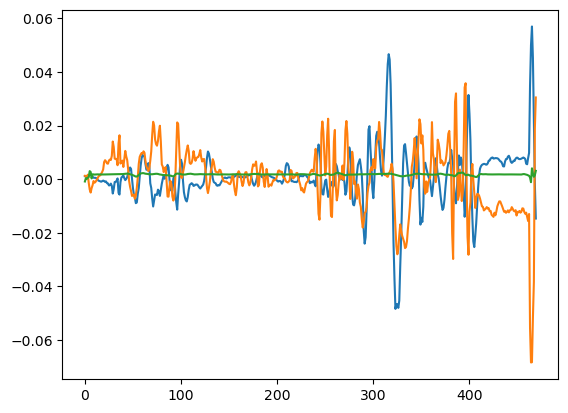

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(ig_data_stl[0])
plt.plot(ig_data_stl_2[0])
plt.plot(pred[1][0])
plt.show()
    #ig_model.predict(data[2])[1][0])

In [2]:
import tensorflow as tf
from captum.attr import IntegratedGradients

model = ig_model
# Choose the branch of the MTL system that you want to measure the impact for.
branch = 'task_2'

# Calculate the integrated gradients for the input data and labels.
ig = IntegratedGradients(model, branch)
attributions = ig.explain(tf.zeros([1, 28, 28, 1]), baselines=tf.zeros([1, 28, 28, 1]))

# The integrated gradients for the input data will be a vector of scores, one for each input feature.
scores = attributions['attributions']

# The score for a particular input feature indicates how important it is for the model's prediction for the branch that you chose.
print(scores)

OSError: [WinError 182] Das Betriebssystem kann %1 nicht ausführen. Error loading "c:\Users\boent\anaconda3\envs\xai-tsc\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.